# Optimal Policies with Dynamic Programming

In this notebook we're going to understand:

- Policy Evaliation and Policy Improvement
- Value and Policy Iteration
- Bellman Equations

## Preliminaries

First of all, let's run the preliminary code to execute this notebook. Here we're loading the required libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import gym
import numpy as np
from IPython import display
import time

## Frozen Lake

Frozen Lake is a simple environment provided by OpenAI's gym, in which you are on a frozen lake and need to reach a specific state. The frozen lake, however, has holes in it, and if you end up in one of those goals, you die. Our objective is to implement an agent that is capable of reaching the goal in an optimal fashion.

### Problem's description:

Our environment can be understood as a 4x4 grid world, $S^{+}=\left\{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15\right\}$
notice that this is $S^{+}$, which means it contains the terminal states

Our agent has an action space of size $\mid A\mid = 4$ where $A = \left\{0, 1, 2, 3\right\}$

Actions:

- 0: Left
- 1: Down
- 2: Right
- 3: Up

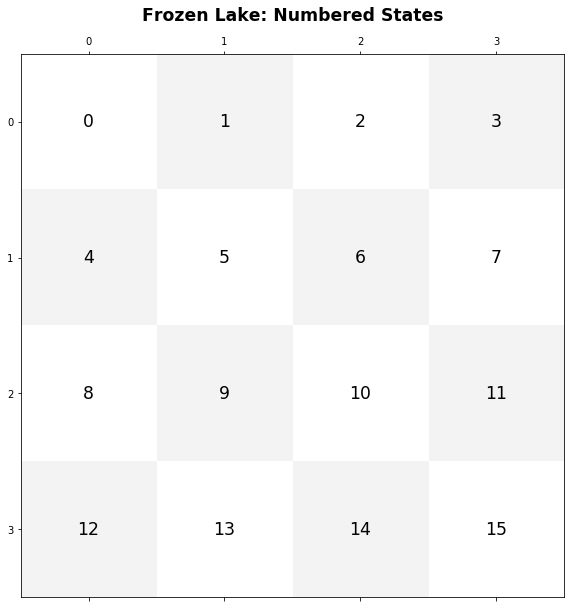

In [2]:
# this code is for visualization only
visual_states = np.arange(16).reshape((4,4))
visual_colors = np.array([[1,0.95,1,0.95],[0.95,1,0.95,1]]*2)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title(label='Frozen Lake: Numbered States', fontsize='xx-large', fontweight='bold')

ax.matshow(visual_colors, cmap='gray', vmin=0, vmax=1)

for (i, j), z in np.ndenumerate(visual_states):
    ax.text(j, i, '{:}'.format(z), ha='center', va='center', fontsize='xx-large', fontweight='roman')
    
plt.show()

Each state can be specified as:

- S: Starting state, safe
- F: Frozen surface, safe
- H: Hole, unsafe
- G: Goal, safe objective

Here's another representation of the grid above, now showing the state labels and colors to easily identify them

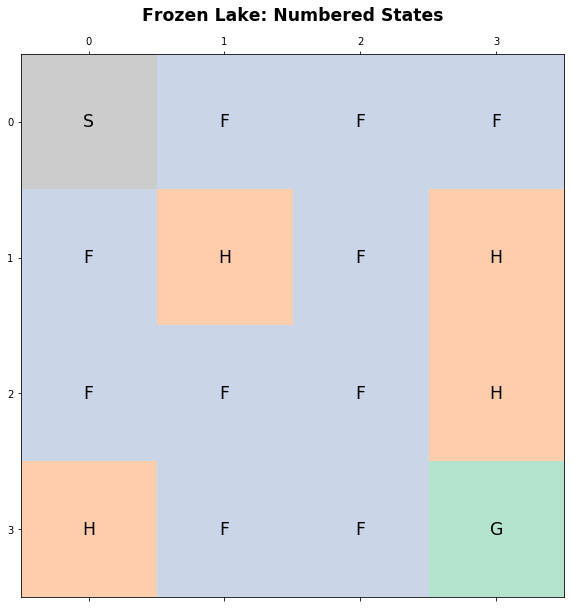

In [3]:
# this code is for visualization only
visual_states = np.array([['S','F','F','F'],
                          ['F','H','F','H'],
                          ['F','F','F','H'],
                          ['H','F','F','G']
                         ])
visual_colors = np.array([[6,1,1,1],
                          [1,0,1,0],
                          [1,1,1,0],
                          [0,1,1,-1]
                         ])

fig, ax = plt.subplots(figsize=(10, 10))
plt.title(label='Frozen Lake: Numbered States', fontsize='xx-large', fontweight='bold')

ax.matshow(visual_colors, cmap='Pastel2')

for (i, j), z in np.ndenumerate(visual_states):
    ax.text(j, i, '{:}'.format(z), ha='center', va='center', fontsize='xx-large', fontweight='roman')
    
plt.show()

Enough explanation, let's declare the environment using gym's API

In [4]:
gym.envs.register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.78, # optimum = .8196
)

env = gym.make('FrozenLakeNotSlippery-v0')

An important point to make is that the Frozen Lake is by default a stochastic environment. When an action is taken on a given state, there is a chance that we do not land on the expected state given by the fact that the lake is 'slippery', causing us to land somewhere else. the gym interface doesn't provide us with a transition model we can sample, which means that the stochastic problem would not be solvable by DP. This is why we declare `'is_slippery': False` to make the environment deterministic.

Let's get some info from the environment, to check that everything follows from the previous explanation

In [5]:
state_space_size = env.observation_space.n
state_space = np.arange(state_space_size)
action_space_size = env.action_space.n
action_space = np.arange(action_space_size)

print('State Space Magnitude: ', state_space_size)
print('Action space Magnitude: ', action_space_size)

State Space Magnitude:  16
Action space Magnitude:  4


## Observing the environment behavior

We can observe an 'equiprobable-random-policy agent' simply by sampling our environment. Let's see how it behaves! Run the next cell code to get a new window displaying our agent doing some random walks!

In [45]:
env.reset()
is_done = False # Restart the environment if we reach a terminal state

for i in range(30):
    print('Step: ', i)
    env.render()
    if is_done:
        env.reset()
        print("RESTART")
        
    time.sleep(.5) 
    display.clear_output(wait=True)
    # Take a random action
    _, _, is_done, _ = env.step(env.action_space.sample()) 

print('DONE')
env.close()

DONE


Let's point out some things about this simulation. As we have seen, all actions returned the expected state, which proves our environment is deterministic. Those actions that would have taken us outside of the grid keep us in place.

Now that the environment has been understood, let's start working on solving this MDP. For us to reach an optimal policy, we need to know the values of each state, and map each state with an action that would maximize our return. We're going to create some variables to store this data

We can store our value function in a vector of magnitude $\mid S^{+} \mid$, where the *i*-th entry gives the value of the *i* space being occupied

In [7]:
V = np.zeros(state_space_size)
V

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

As for the policy `pi`, we're going to declare a matrix of size $n\times m$, where $n = |S^{+}|, m = |A|$. An important property of our policy matrix is that each row should add up to one, as our policy represents a distribution of actions over all states

In [8]:
pi = np.ones((state_space_size, action_space_size)).astype(np.float64)/action_space_size
pi

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

Since our policy has not been improved, we've declared it as an equiprobable-random-policy. This means that for all states, every action has the same chance of being selected

Let's build a function to easily plot this values, so we can get a grasp of what's going behind the curtains

In [42]:
def plot_v_pi(v, pi):
    f, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(10,16))
    
    ax1.matshow(v.reshape((4,4)), cmap='Blues', vmin=0)
    ax1.set_title(label='Value', fontsize=32)
    ax1.set_xticks(np.arange(-.5, 4, 1), minor=True);
    ax1.set_yticks(np.arange(-.5, 4, 1), minor=True);
    ax1.grid(which='minor', color='w', linestyle='-', linewidth=2)

    for (i, j), z in np.ndenumerate(v.reshape((4,4))):
        ax1.text(j, i, '{:.3f}'.format(z), ha='center', va='center')
    
    ax2.matshow(pi.transpose(), cmap='Reds', vmin=0, vmax=1)
    ax2.set_title(label='Policy', fontsize=32)
    ax2.set_xlabel('State', fontsize=24)
    ax2.set_ylabel('Action', fontsize=24)
    ax2.set_xticks(np.arange(-.5, pi.shape[0], 1), minor=True);
    ax2.set_yticks(np.arange(-.5, pi.shape[1], 1), minor=True);
    ax2.set_yticklabels(labels=['','left','down','right','up'])
    ax2.grid(which='minor', color='w', linestyle='-', linewidth=2)
    
    for (i, j), z in np.ndenumerate(pi.transpose()):
        ax2.text(j, i, '{:.2f}'.format(z), ha='center', va='center')

    visual_colors = np.array([[6,1,1,1],
                              [1,0,1,0],
                              [1,1,1,0],
                              [0,1,1,-1]
                             ])
    
    ax3.matshow(visual_colors, cmap='Pastel2')
    ax3.set_title(label='Policy in the environment', fontsize=32)
    ax3.set_xticks(np.arange(-.5, 4, 1), minor=True);
    ax3.set_yticks(np.arange(-.5, 4, 1), minor=True);
    ax3.grid(which='minor', color='w', linestyle='-', linewidth=2)
    
    # Plot arrows indicating the directions the policy would take.
    # The magnitude represents how probable that action would be under that state
    for (i, j, a), z in np.ndenumerate(pi.reshape((4,4,4))):
        # Transformation matrix. Used to rotate the direction vector for the arrow
        rot_matrix = np.array([[0, 1],
                               [-1,0]])
        dir_vec = np.array([-1,0]).transpose()
        # Rotate 90 degrees counter-clockwise times the number of the action
        op = np.linalg.matrix_power(rot_matrix, a)
        arrow_dir = np.matmul(op, dir_vec)
        if (z):
            # z represents the probability of taking a in state [i,j]
            ax3.arrow(x=j, 
                      y=i, 
                      dx=0.3*z*arrow_dir[0], 
                      dy=0.3*z*arrow_dir[1],
                      head_width=0.1,
                      width=0.005
                     )
    plt.show()

Let's do an example to see how the plot looks

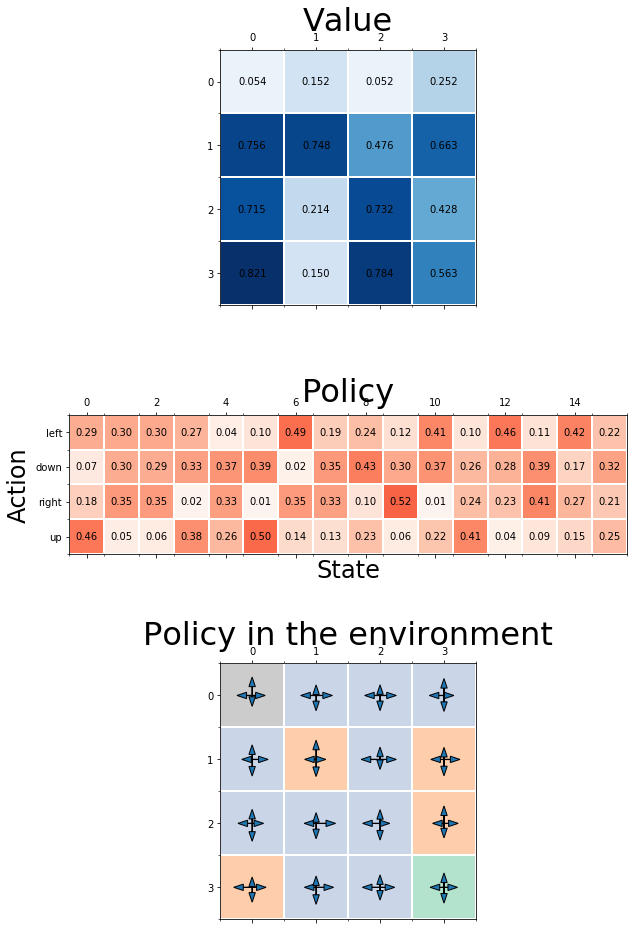

In [44]:
mock_V = np.random.random_sample(size=(state_space_size))
mock_pi = np.random.random_sample(size=(state_space_size, action_space_size))
mock_pi = mock_pi.transpose() / mock_pi.sum(axis=1)
mock_pi = mock_pi.transpose()
plot_v_pi(mock_V, mock_pi)

### Getting the transition model

gym's API doesn't provide us with a means to get a transition model from the environment. This makes sense, as the intention of gym is for us to build an agent that can behave optimally without having access of such data, since in the real world there's rarely a way to obtain an accurate model of any problem. Because we intend to explore Dynamic Programming, it's up to us to build our own transition model. Thankfully, using the [environment's repository](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py) we can easily build an accurate model based on how they transition from state to state.

In [11]:
def transition_model(state, action, desc):
    r = desc.shape[0]
    c = desc.shape[1]
    row = state // c
    col = state % c
    next_states_idx = [
        [row, max(col - 1, 0)], # s' coordinates for taking action 0
        [min(row + 1, r-1), col], # s' coordinates for taking action 1
        [row, min(col + 1, c-1)], # s' coordinates for taking action 2
        [max(row - 1, 0), col], # s' coordinates for taking action 3
    ]
    next_states = [row*c+col for (row,col) in next_states_idx]
    
    rewards = [(desc[i, j] == b'G') for (i,j) in next_states_idx]
    probs = [(float)(action == idx) for idx in np.arange(len(next_states_idx))]
    if desc[row,col]==b'G' or desc[row,col]==b'H':
        # set zero probability for any transition on terminal states
        probs = [0. for _ in probs]
    return np.array([next_states, rewards, probs]).transpose()


Let's see an example of this transition model. The model returns a list of possible next states, each of them with their respective reward and their respective probability distribution.

In [12]:
state = 1
action = 1
transitions = transition_model(state, action, env.desc)
print(transitions)

[[0. 0. 0.]
 [5. 0. 1.]
 [2. 0. 0.]
 [1. 0. 0.]]


Since our task is deterministic, we see that our distribution is zero for every state other than the one that would be reached by taking the desired action. Every action gives us a reward of 0 except for those actions that take us to the goal. How then, do we discourage our agent from going to holes? let's see what happens if we try to move while being on a hole:

In [13]:
state = 5
action = 1
transitions = transition_model(state, action, env.desc)
print(transitions)

[[4. 0. 0.]
 [9. 0. 0.]
 [6. 0. 0.]
 [1. 0. 0.]]


Notice something strange is going on... No possible state can be reached, because the probability of transitioning to any other state is 0! This is the special case with terminal states, and also occurs with the Goal state. The difference is that entering into the goal gives us a positive reward.

## Section 1: Policy Evaluation

We're now ready to start doing some Policy evaluation! Since we know the transition model of our environment, we can easily evaluate how good our equiprobable-random-policy behaves. This is called *Policy Evaluation*, and is done by iteratively applying the Bellman equation for $v_\pi$ as an update rule until convergence, as shown below.

<h3><center>$v(s) \leftarrow \sum_{a} \pi(a|s)\sum_{s',r}p(s', r|s, a)[r + \gamma v(s')]$</center></h3>

This update can either occur "in-place" (i.e. the update rule is sequentially applied to each state) or with "two-arrays" (i.e. the update rule is simultaneously applied to each state). Both versions converge to $v_\pi$ but the in-place version usually converges faster. **Here we're going to implement all update rules in-place**

In [14]:
def evaluate_policy(env, V, pi, gamma, theta):
    while True:
        delta = 0
        for s in state_space:
            v = V[s]
            bellman_update(env, V, pi, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V

In [15]:
def bellman_update(env, V, pi, s, gamma):
    new_val = 0
    for a in action_space:
        pi_prob = pi[s,a]
        transition_dist = transition_model(s,a,env.desc)
        ret = np.array([prob*(r + gamma*V[int(n_s)]) for (n_s, r, prob) in transition_dist.tolist()]).sum()
        
        new_val += pi_prob*ret
        
    V[s] = new_val

Let's see how our value function changes after a single policy evaluation with our random policy

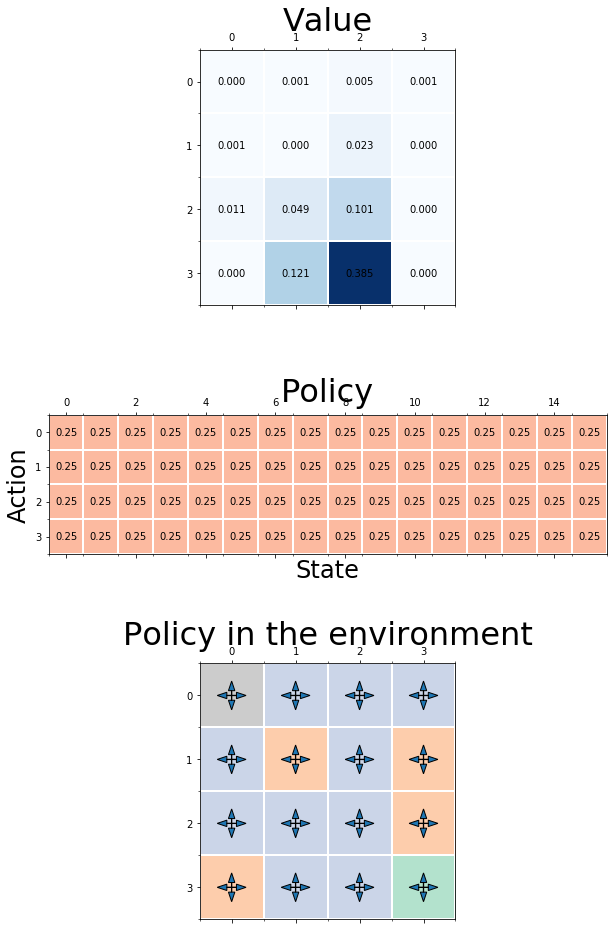

In [16]:
V = np.zeros(state_space_size)
pi = np.ones((state_space_size, action_space_size)).astype(np.float64)/action_space_size
gamma = 0.9
theta = 0.01

V = evaluate_policy(env, V, pi, gamma, theta)
plot_v_pi(V, pi)

We can observe that with a single iteration of policy evaluation, already we get a value distribution that showcases paths for us to get to the goal, while also (barely) avoiding the holes! Note though, that our policy hasn't changed, and it will still behave randomly. That's because the only thing we've done so far is evaluate each state under the current policy. Next comes policy improvement

## Section 2: Policy Iteration

Now we wish to compute a more efficient policy to follow, using what we know so far about the environment and it's values. Policy Iteration works by alternating between evaluating the existing policy and making the policy greedy with respect to the existing value function.

As a refresher, the new policy is defined as that one which greedifies the action-value function, as Below

$\pi'(s) \doteq argmax_a q_\pi (s,a)$

$\pi'(s) = argmax_a\mathbb{E}[R_{t+1} + \gamma v_\pi(S_t+1) | S_t=s, A_t=a]$

$\pi'(s) = argmax_a\sum_{s',r}p(s',r|s,a)[r + \gamma v_\pi(s')]$

In [17]:
def improve_policy(env, V, pi, gamma):
    policy_stable = True
    for s in state_space:
        # Greedify the policy in each state
        old = pi[s].copy()
        q_greedify_policy(env, V, pi, s, gamma)
        if not np.array_equal(pi[s], old):
            # If the policy has changed, then it's not currently stable
            policy_stable = False
    return pi, policy_stable

def q_greedify_policy(env, V, pi, s, gamma):
    # Compute the action-value function for all actions
    transitions = np.array([prob*(r + gamma*V[int(n_s)]) for a in action_space for (n_s, r, prob) in transition_model(s, a, env.desc)]).reshape((action_space_size, -1))
    # Sum over all next_states so we obtain q of the current state
    q = transitions.sum(axis=1)
    # q is now a vector of size action_space(s), where each value
    # indicates the expected return for each action in that current state
    # The index is the chosen action
    
    # Get the greedy action. In case of ties, distribute equally
    max_mask = (q == q.max()).astype(np.float32)
    max_mask /= max_mask.sum()
    
    # Greedify the policy, by overwriting the current policy and choosing action a
    pi[s] = max_mask
    
    # we're done!
    

Let's see how our policy changes after doing a single step of policy iteration

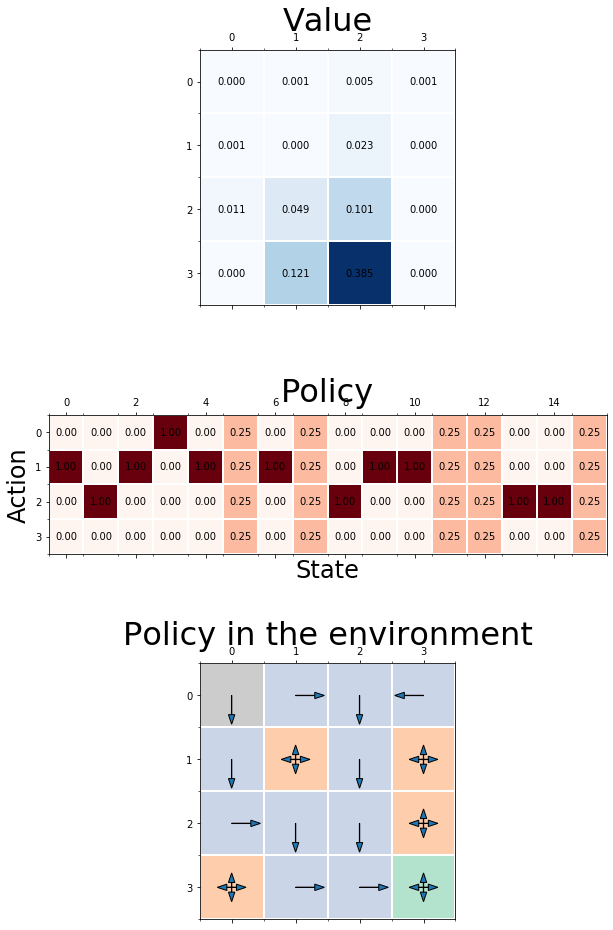

In [18]:
improve_policy(env, V, pi, gamma)
plot_v_pi(V, pi)

This already looks like an optimal solution! And we only had to make a single policy evaluation and policy improvement... That's efficiency!

For this task, getting an optimal policy was incredibly simple, but it may not be the case all the time. Most environments require multiple iterations for us to reach an optimal policy. For the sake of completeness, we're going to assume this is our case.


## Section 3: Policy iteration

We've already seen how to obtain the value of each state by evaluating a given policy with the Bellman Update. Similarly, we've seen how to update our policy so that it behaves better than the previously evaluated. We can execute this process of evaluating a policy and updating it multiple times, and it is ensured that this process will converge to the optimal policy $\pi*$ on the limit. Let's implement this process by iterating over both operations until there's no change in our policy

In [19]:
def policy_iteration(env, gamma, theta):
    V = np.zeros(state_space_size)
    pi = np.ones((state_space_size, action_space_size)).astype(np.float64)/action_space_size
    policy_stable = False
    i = 0
    while not policy_stable:
        V = evaluate_policy(env, V, pi, gamma, theta)
        pi, policy_stable = improve_policy(env, V, pi, gamma)
        i += 1
    print('Converged! Number of steps required: ', i)
    return V, pi


Now we're ready to execute policy iteration, and observe the final results

Converged! Number of steps required:  4


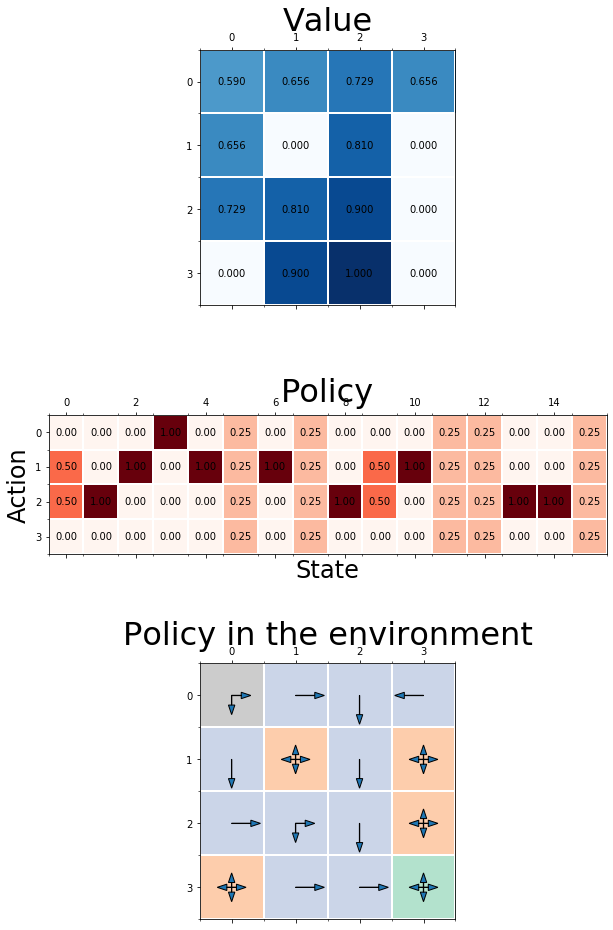

In [20]:
gamma = 0.9
theta = 0.1
V, pi = policy_iteration(env, gamma, theta)
plot_v_pi(V, pi)

Fantastic! Let's see our agent behaving under this new optimal policy!

In [47]:
env.reset()
is_done = False # Restart the environment if we reach a terminal state

s = 0 # Initial state

for i in range(30):
    print('Step: ', i)
    env.render()
    if is_done:
        env.reset()
        print("RESTART")
        
    time.sleep(.5) 
    display.clear_output(wait=True)
    # Take a sampled action from our policy distribution
    a = np.random.choice(action_space_size, p=pi[s])
    s, _, is_done, _ = env.step(a)

print('DONE')
env.close()

DONE


## Section 3: Value Iteration

We've already seen how we can obtain an optimal policy by iteratively going between policy evaluation and policy improvement. This process ensures convergence, but has some computational limitations. Policy evaluation, as currently defined, requires us to reach convergence on the value function for each policy. This can easily become a long task when the number of states increases. Also, sometimes it may not even be productive to reach convergence on every step. It is actually possible to truncate the process of policy evaluation, and still converge to the optimal policy and value function. This is what value iteration does.

Value iteration takes one of the Bellman Optimality equations and turns it into an update function, like below

$v_{k+1}(s) \doteq max_a\mathbb{E}[R_{t+1} + \gamma v_k(S_{t+1}) | S_t=s, A_t=a]$

$v_{k+1}(s) = max_a\sum_{s',r}p(s',r | s,a)[r + \gamma v_k(s')]$,

for all $s \in S$

Let's see how we can implement this

In [30]:
def value_iteration(env, gamma, theta):
    V = np.zeros(state_space_size)
    i = 0
    while True:
        delta = 0
        i += 1
        for s in state_space:
            v = V[s]
            bellman_optimality_update(env, V, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            print('Converged! Number of steps required: ', i)
            break
    pi = np.ones((state_space_size, action_space_size)) / action_space_size
    for s in state_space:
        q_greedify_policy(env, V, pi, s, gamma)
    return V, pi

In [31]:
def bellman_optimality_update(env, V, s, gamma):
    transitions = np.array([prob*(r + gamma*V[int(n_s)]) for a in action_space for (n_s, r, prob) in transition_model(s, a, env.desc)]).reshape((action_space_size, -1))
    # Sum over all next_states so we obtain q(s)
    q = transitions.sum(axis=1)
    # Set the value function of the current state to the maximum value seen over all actions
    V[s] = np.max(q)

Converged! Number of steps required:  7


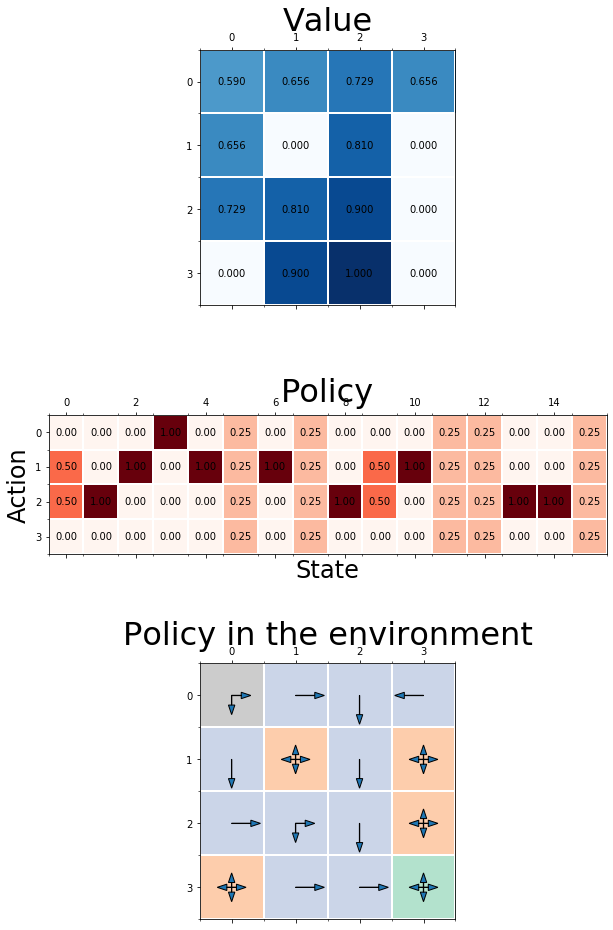

In [32]:
gamma = 0.9
theta = 0.1
V, pi = value_iteration(env, gamma, theta)
plot_v_pi(V, pi)

As you can see, value iteration has taken us to the same policy, although it took more steps to get there. This is fine, some situations don't pose any advantage between both methods (policy vs. value iteration).